<a href="https://colab.research.google.com/github/Frederick-Stein/Data-Science-Playground/blob/main/MNIST_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms
from  pathlib import Path
# from torchmetrics.classification import Accuracy
from timeit import default_timer as timer

In [6]:
# 1) Transforms (tensor + normalize to MNIST stats)
generator1 = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              ])

# 2) Datasets (downloaded to ./data)
train_data = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
class_name = train_data.classes

print(f"Train data shape: {train_data}")

# 3) Split data into train and validation
train_data, val_data = random_split(train_data, [55000, 5000], generator=torch.Generator().manual_seed(41))

# 4) Set device and loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
pin = (device.type == "cuda")

train_loader = DataLoader(train_data, batch_size = 128, shuffle = True, pin_memory = pin)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = True, pin_memory = pin)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = True, pin_memory = pin)

Train data shape: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Device: cuda


In [3]:
## Define a timer
def train_time(start, end, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")

In [ ]:
# class ClassificationNN(nn.Module):

#     def __init__(self, sizes):

#         super().__init__()

#         self.num_layers = len(sizes)
#         self.sizes = sizes

#         self.weights = nn.ParameterList([nn.Parameter(torch.randn(y, x)) for x, y in zip(sizes[:-1], sizes[1:])])
#         self.biases = nn.ParameterList([nn.Parameter(torch.randn(y)) for y in sizes[1:]])

#     def forward(self, x):
#         x = x.view(x.shape[0], -1)
#         for i in range(self.num_layers - 1):
#             y = torch.mm(x, self.weights[i].T) + self.biases[i]
#             if i != self.num_layers - 2:
#                 # Sigmoid activation for all layers
#                 x = torch.sigmoid(y)

#                 # ReLU activation for all layers except the last one
#                 # x = F.relu(y)
#             else:
#                 x = y

#         return x

In [ ]:
# class ClassificationNN(nn.Module):

#     def __init__(self, sizes):

#         super().__init__()

#         self.num_layers = len(sizes)
#         self.sizes = sizes

#         self.layers = nn.ModuleList([nn.Linear(x, y) for x, y in zip(sizes[:-1], sizes[1:])])
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.tanh = nn.Tanh()

#     def forward(self, x):
#         x = x.view(x.shape[0], -1)
#         for layer in self.layers[:-1]:
#             # x = torch.sigmoid(layer(x))  # hidden layers
#             # x = self.relu(layer(x))
#             x = self.tanh(layer(x))

#         x = self.layers[-1](x)  # last layer (logits)
#         return x

In [4]:
class ClassificationNN(nn.Module):

    def __init__(self, sizes):

        super().__init__()

        self.activiation = nn.ReLU()
        # self.activiation = nn.Sigmoid()
        # self.activiation = nn.Tanh()

        layers = [nn.Flatten()]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i != len(sizes) - 2:
                layers.append(self.activiation)
        self.layer_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer_stack(x)

In [5]:
X_0, y_0 = next(iter(train_loader))
print(X_0.shape, y_0)
device
model = ClassificationNN([784, 30, 10]).to(device)
X_0= X_0.to(device)
model(X_0)

torch.Size([128, 1, 28, 28]) tensor([0, 9, 1, 9, 4, 9, 4, 2, 4, 1, 5, 4, 2, 1, 3, 6, 0, 2, 2, 5, 8, 3, 7, 7,
        7, 4, 4, 1, 0, 2, 4, 7, 0, 2, 5, 3, 2, 7, 7, 2, 9, 3, 7, 7, 7, 3, 2, 2,
        2, 1, 7, 3, 8, 2, 8, 1, 1, 3, 6, 8, 3, 0, 0, 7, 6, 6, 4, 6, 6, 7, 5, 5,
        2, 1, 2, 0, 3, 3, 6, 5, 9, 0, 0, 2, 5, 8, 3, 6, 8, 1, 6, 0, 4, 5, 3, 8,
        8, 9, 7, 0, 7, 3, 2, 5, 3, 8, 7, 2, 2, 6, 1, 2, 8, 3, 9, 3, 3, 3, 8, 5,
        8, 9, 5, 2, 3, 5, 1, 6])


tensor([[ 0.1813, -0.6054,  0.4801,  ...,  0.6788,  0.4356, -0.3322],
        [ 0.1788, -0.1329,  0.2133,  ...,  0.3504,  0.1695, -0.0389],
        [ 0.1800, -0.0231,  0.1671,  ...,  0.5350,  0.1250, -0.1073],
        ...,
        [ 0.0082, -0.0441,  0.2203,  ...,  0.8350,  0.5119, -0.3560],
        [ 0.1662, -0.2030,  0.2662,  ...,  0.2692,  0.0049, -0.0893],
        [ 0.4891, -0.5540,  0.4723,  ...,  0.4702,  0.1076, -0.3000]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
## Move the model to the device
model = ClassificationNN([784, 30, len(class_name)]).to(device)

## Loss function
loss_fcn = nn.CrossEntropyLoss()

## Optimization method
# optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay= 1e-4)


## Metric setup
# accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

epochs = 20
train_error = []
test_error = []
train_accuracy = []
test_accuracy = []
epoch_range = []

train_time_start = timer()

for epoch in range(1, epochs+1):

    model.train()
    train_loss = 0
    correct_train = 0
    # accuracy_metric.reset()

    for X_batch, y_batch in train_loader:

        # Move data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Feedforward
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fcn(y_pred, y_batch)

        # Initialize optimizer
        optimizer.zero_grad()

        # Back-propogation
        loss.backward()

        # Gradient descent
        optimizer.step()

        train_loss += loss.detach().item() * X_batch.size(0)
        predicted = y_pred.argmax(dim=1)
        correct_train += (predicted == y_batch).sum().item()
        # accuracy_metric.update(predicted, y_batch)

    train_loss /= len(train_data)
    train_acc = correct_train / len(train_data) * 100 # train accuracy
    # train_acc = accuracy_metric.compute().item() * 100

    model.eval()
    with torch.inference_mode():
        correct_test = 0 # accuracy
        test_loss = 0
        # accuracy_metric.reset()


        for X_batch, y_batch in test_loader:
            # Move data to device
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            # Training process
            y_pred = model(X_batch)

            loss = loss_fcn(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)

            # Calculate accuracy
            predicted = y_pred.argmax(dim=1)
            correct_test += (predicted == y_batch).sum().item()
            # accuracy_metric.update(predicted, y_batch)

        test_loss /= len(test_data)
        test_acc = correct_test / len(test_data) * 100
        # test_acc = accuracy_metric.compute().item() * 100

        train_error.append(train_loss)
        test_error.append(test_loss)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        epoch_range.append(epoch)

        if epoch % 5 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Test loss: {test_loss: .4f} | Test accuracy: {test_acc:.2f}%")

train_time_end = timer()
train_time(train_time_start, train_time_end, device)

Epoch: 5 | Train loss:  0.1317 | Test loss:  0.1347 | Test accuracy: 95.97%
Epoch: 10 | Train loss:  0.0875 | Test loss:  0.1167 | Test accuracy: 96.67%
Epoch: 15 | Train loss:  0.0677 | Test loss:  0.1109 | Test accuracy: 96.81%
Epoch: 20 | Train loss:  0.0550 | Test loss:  0.1126 | Test accuracy: 96.86%
Train time on cuda: 255.835 seconds


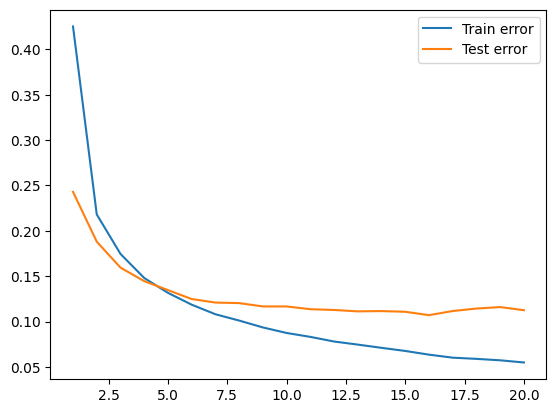

In [12]:
# Plot error
plt.plot(epoch_range, train_error, label = "Train error")
plt.plot(epoch_range, test_error, label = "Test error")
plt.legend()

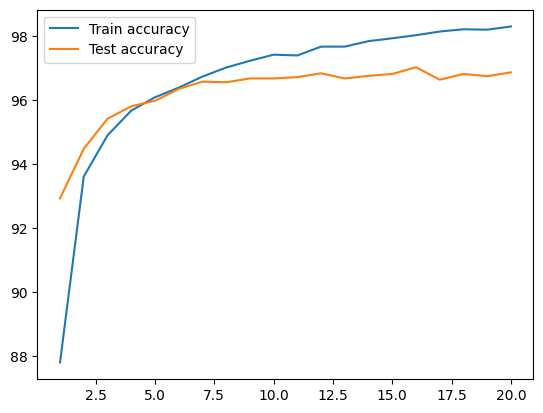

In [13]:
# Plot accuracy
plt.plot(epoch_range, train_accuracy, label = "Train accuracy")
plt.plot(epoch_range, test_accuracy, label = "Test accuracy")
plt.legend()

In [ ]:
## Save and load

# Create models direcory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = 'NNclassification_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model state dict
torch.save(model.state_dict(), f = MODEL_SAVE_PATH)

# Save model
# torch.save(model, f= MODEL_SAVE_PATH)

# Load Model
# loaded_model = ClassificationNN([784, 30, 10])
# loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>